# Natural Language Processing
## Fake News Detection Using Random Forest, logistic regression, SVM and Naive Bayes.

In [73]:
!pip3 install pytest-runner --upgrade
!pip3 install ftfy

In [74]:
import ftfy
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
import pandas as pd
import csv
import numpy as np
import warnings
import json
import re
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [75]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import Binarizer
from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split
from wordcloud import STOPWORDS, WordCloud
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore')
np.random.seed(0)

# Loading the LIAR Dataset

---
The data is categorised into four tab-separated files. It's being loaded as a pandas dataframe. Creating a single file from the train, test, and validation files so that we can conduct the train and test split as needed.

#Mounting the dataset through Google drive 

In [76]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [77]:
# Importing the dataset
train = pd.read_csv('/content/gdrive/MyDrive/project/enter/data/train.tsv', delimiter='\t', quoting=3, header=None)
test = pd.read_csv('/content/gdrive/MyDrive/project/enter/data/test.tsv', delimiter='\t', quoting=3, header=None)
valid = pd.read_csv('/content/gdrive/MyDrive/project/enter/data/valid.tsv', delimiter='\t', quoting=3, header=None)

In [78]:
raw_dataframe = pd.concat([train, test, valid], axis=0, sort=False)
raw_dataframe = raw_dataframe.sample(frac=1).reset_index()
print(raw_dataframe.shape)
raw_dataframe.columns=["index","ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
raw_dataframe.head(5)

(12836, 15)


,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes
2,5306,12759.json,pants-fire,Says Ted Cruz never denied his father was phot...,"candidates-biography,crime,history",donald-trump,President-Elect,New York,republican,63,114,51,37,61,a campaign rally in Cleveland
3,9463,8896.json,true,Its been 14 years since a president or a vice ...,sports,candy-crowley,CNN host,NaN,none,0,0,0,0,0,"comments on CNN's ""State of the Union"""
4,3638,11241.json,half-true,"In the year 2013, the Obama administration rel...","crime,criminal-justice,immigration",ted-cruz,Senator,Texas,republican,36,33,15,19,8,answering a reporter in Iowa


#printing the first 15 statement by speaker in list form the csv file

In [79]:
# some of the statements
raw_dataframe['statement'].head(15).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.',
 'Says the United States does not trade as much as other developed nations.',
 '"Oil companies ...currently have 68-million acres that they\'re not using."',
 'Says 24 million people in this country cant find a full-time job, 50 million cant see a doctor when theyre sick, 47 million people need government help to feed themselves and 15 million families owe more than the value of their home.',
 'President Obama went around the world and apo

# Exploratory Data Analysis for to check the statement according to dataset


Text(0.5, 1.0, 'statement type and number of classes')

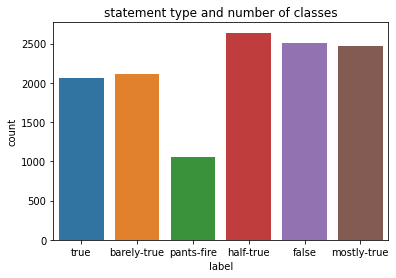

In [80]:
sns.countplot(x='label',data=raw_dataframe)
plt.title('statement type and number of classes')

### Converting multiclass labels to two classes - Fake and True for exploratory data analysis

#function for mapping labels "true, mostly-true, half-true" to TRUE and "false, barely-true, pants-fire" to FAKE.

In [81]:

def binary_class_dataset(input):
    
    input = input.iloc[:, [2, 3]]
    input.columns = ['label', 'statement']
    Original_labels = {
        'true': 'True',
        'mostly-true': 'True',
        'half-true': 'True',
        'false': 'False',
        'barely-true': 'False',
        'pants-fire': 'False'
    }
    input['label'] = input['label'].map(Original_labels)

    return input

# running the function on the loaded dataframe
#and converting into newdataframe to use in the different models

In [82]:
new_df= binary_class_dataset(raw_dataframe)

## preparing Word Clouds for the text statements in the dataset
# creating two dataset consisting of True and Fake statements seperately

In [83]:

np.random.seed(0)
true_statements_dataset = new_df[new_df['label'].astype(str) == 'True']
fake_statements_dataset = new_df[new_df['label'].astype(str) == 'False']

### Exploring the 'speakers' who have given the statements in the LIAR dataset
#finding the total number of unique 'speakers' in the LIAR

In [84]:

speakers_info = raw_dataframe.copy()
speakers = speakers_info['speaker'].unique()

print("Number of speakers in the Data is : %d  " % len(speakers))
print("Some top 10 speakers are:\n", speakers[:10].tolist())

Number of speakers in the Data is : 3318  
Some top 10 speakers are:
 ['moveon', 'matt-lauer', 'donald-trump', 'candy-crowley', 'ted-cruz', 'rob-portman', 'barack-obama', 'alan-grayson', 'mitt-romney', 'joe-biden']


#displaying all the speakers in exploratory plot will not be possible nor meaningful. Hence finding the top speakers who have made frequent statements

In [85]:
speakers_cts = speakers_info.groupby("speaker").statement.count()
# speakers who have made more than 100 statements.
speakers = speakers_cts[speakers_cts > 100] 
print("The speaker have made  %d statements more than 50 times in the dataset" % len(speakers))

print("Some of the speakers and the number of statements made by them are:\n", speakers[:10])

The speaker have made  13 statements more than 50 times in the dataset
Some of the speakers and the number of statements made by them are:
 speaker
barack-obama       616
bernie-s           107
chain-email        178
chris-christie     105
donald-trump       344
hillary-clinton    297
john-mccain        189
marco-rubio        153
mitt-romney        216
rick-perry         173
Name: statement, dtype: int64


#Limiting ourselves to only prominent speakers for visualization

In [86]:

speakers_info = speakers_info[speakers_info['speaker'].isin(speakers.keys())]

#function to groupby the speakers by the class and count of statements spoken individuals

In [87]:
def class_counts(input, column):
    return input.groupby([column,"label"]).agg({"ID" : "count"})


#### Plot of top 13 speakers in the LIAR dataset labelled by class and count of statements they have given.

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made')

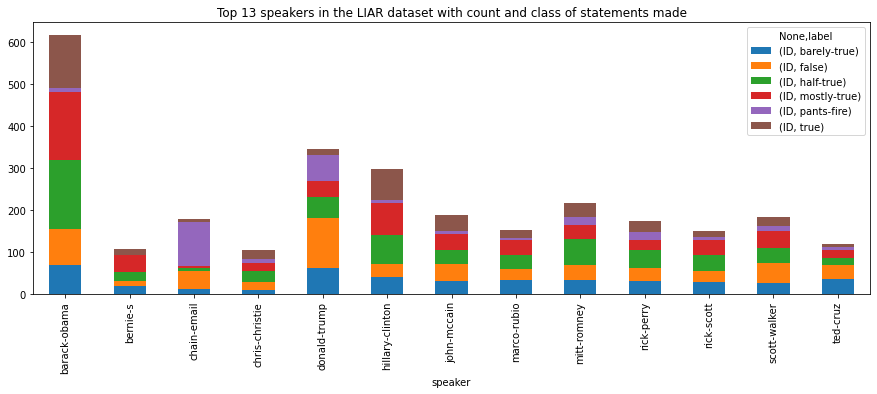

In [88]:
# stacked bar plot of speakrs with class and count of statements
breakdown = class_counts(speakers_info, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made")

# Normalising the statements and the speakers for comparison purpose


In [89]:

def normalize(input, column):
    norm = input.reset_index()
    norm = norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_totals = norm.sum(axis=1)
    for row in range(len(norm.index)):
        norm.iloc[row]/= row_totals[row]

    norm = norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return norm

#### Normalised plot of top 13 speakers in the LIAR dataset labelled type of statements they have given (for comparison)

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made by them')

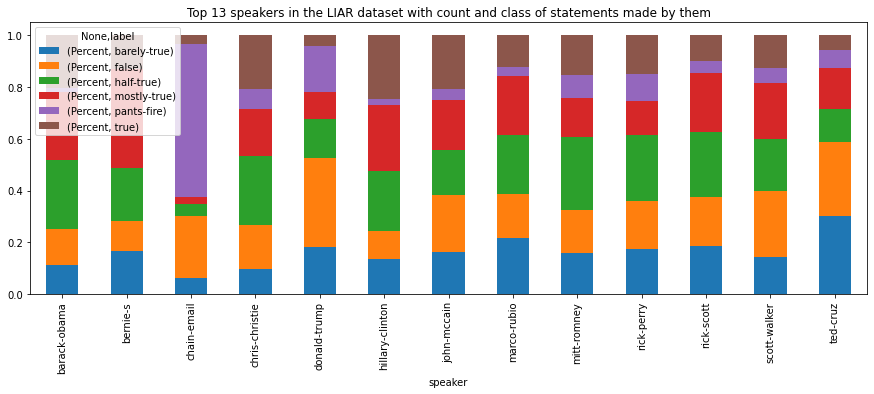

In [90]:
unifrom_data = normalize(breakdown, 'speaker')
unifrom_data.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made by them")

In comparison to other speakers, Facebook postings, Chain emails, and Donald Trump have a larger number of 'pant on fire' false claims. We should also observe that, despite making the most remarks, Obama's pant-on-fire utterances are practically non-existent.

# Using CountVectorizer for Extracting features from 'statements' in LIAR dataset

In [91]:
# specifying features and labels
X_data= raw_dataframe['statement']
y_data=raw_dataframe['label']

# specifying train and test split with ratio of 70:30

In [92]:

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.3, stratify=y_data)


###creating Custom Pre - Processing and Tokenisation of the data


---


# Regular expression for cleaning the statements


---

#Preprocessing the text in the statements


---
#regular expression for custom tokenisation


---





In [93]:
hashtag_removal = re.compile(r"#\w+")
mention_removal = re.compile(r"@\w+")
url_removal = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
extras_removal = re.compile("[.;:!\'?,\"()\[\]]")

def preprocess(writeup):
    processing_text = hashtag_removal.sub("[hashtag]",writeup)
    processing_text = mention_removal.sub("[mention]",processing_text)
    processing_text = extras_removal.sub("",processing_text)
    processing_text = url_removal.sub("[url]",processing_text)
    processing_text = ftfy.fix_text(processing_text)
    return processing_text.lower()

#([]|words|other non-space)


---


# defining 3 types of tokenisation

In [94]:
tokenise_removal = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") 
def custom_tokenise(writeup):
    return tokenise_removal.findall(text.lower())

def Tokenizer(string_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", string_input).lower().split()
    port_stemmer=nltk.PorterStemmer()
    words = [port_stemmer.stem(word) for word in words]
    return words

def nltk_twitter_tokenise(text):
    twitter_token = nltk.tokenize.TweetTokenizer()
    return twitter_token.tokenize(text.lower())

# stop words list set to english

In [95]:
tostop_list = stopwords.words('english') # stop word list

### Defining custom functions for displaying results of Classification

In [96]:
# function for results of cross-validation
def displaying_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))


# fucntion for results of model fitting
def result_display():
    print("Accuracy: ", accuracy_score(y_test, analysis_output))
    print(classification_report(y_test, analysis_output))
    print(confusion_matrix(y_test, analysis_output))
    


#### When documents are shorts as 'statements' in LIAR datasets, using Binarizer for normalisation instead of Tfidf Transformer (i.e. scale to 0 for not present or 1 for presence at any frequency) is beneficial.

In [97]:

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=tostop_list)),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])
model.fit(X_train, y_train)
analysis_output = model.predict(X_test)
result_display()


Accuracy:  0.23863931446377565
              precision    recall  f1-score   support

 barely-true       0.23      0.22      0.22       632
       false       0.25      0.30      0.27       753
   half-true       0.25      0.26      0.25       792
 mostly-true       0.23      0.24      0.23       740
  pants-fire       0.24      0.13      0.17       315
        true       0.23      0.21      0.22       619

    accuracy                           0.24      3851
   macro avg       0.24      0.23      0.23      3851
weighted avg       0.24      0.24      0.24      3851

[[137 151 135 105  27  77]
 [119 228 139 125  43  99]
 [116 153 203 178  27 115]
 [105 154 159 178  13 131]
 [ 54  94  55  44  41  27]
 [ 58 126 132 153  18 132]]


In [98]:
# code to view the selected features
vectorizer = CountVectorizer(analyzer='word')
selector = SelectKBest(chi2, k=100)
feats = vectorizer.fit_transform(X_train)
filtered = selector.fit_transform(feats, y_train)

In [99]:
from itertools import compress
cols = selector.get_support()
names = vectorizer.get_feature_names()

print(list(compress(names,cols)))

['000', '247', 'acted', 'allah', 'and', 'average', 'barack', 'because', 'beliefs', 'benghazi', 'blumenauer', 'bomb', 'boxes', 'boy', 'bulbs', 'care', 'ceremonies', 'college', 'colorado', 'conspiracy', 'creflo', 'cut', 'debt', 'debunked', 'dee', 'duffy', 'earl', 'execution', 'exempted', 'face', 'fear', 'georgia', 'half', 'harvey', 'haslam', 'hillary', 'hip', 'in', 'institution', 'jersey', 'jobs', 'kathy', 'kloppenburgs', 'landrieu', 'last', 'less', 'lowest', 'lying', 'mccain', 'meat', 'million', 'more', 'mormon', 'muslim', 'muslims', 'nose', 'obama', 'obamacare', 'obamas', 'of', 'ops', 'oswald', 'percent', 'photographed', 'plan', 'president', 'protein', 'put', 'radar', 'rate', 'ration', 'rep', 'reps', 'retiree', 'riot', 'rugs', 'says', 'scheme', 'sean', 'sharia', 'sic', 'since', 'socialists', 'society', 'sporting', 'states', 'takeover', 'than', 'the', 'three', 'to', 'today', 'transactions', 'unelected', 'walker', 'wash', 'wic', 'will', 'year', 'your']


In [100]:
# Using Multinomial Naive Bayes classifier
model.set_params(clf=MultinomialNB())
model.fit(X_train, y_train)
analysis_output = model.predict(X_test)
result_display()

Accuracy:  0.25292131913788624
              precision    recall  f1-score   support

 barely-true       0.24      0.20      0.22       632
       false       0.25      0.27      0.26       753
   half-true       0.25      0.36      0.29       792
 mostly-true       0.25      0.31      0.28       740
  pants-fire       0.36      0.08      0.13       315
        true       0.28      0.17      0.21       619

    accuracy                           0.25      3851
   macro avg       0.27      0.23      0.23      3851
weighted avg       0.26      0.25      0.24      3851

[[127 149 186 115   9  46]
 [120 207 193 156  16  61]
 [104 141 283 189   9  66]
 [ 75 127 230 228   5  75]
 [ 53  99  69  46  25  23]
 [ 47 117 183 163   5 104]]


In [101]:
# Fitting C-Support Vector Classifier
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
analysis_output = model.predict(X_test)
result_display()

Accuracy:  0.2339652038431576
              precision    recall  f1-score   support

 barely-true       0.22      0.27      0.24       632
       false       0.24      0.29      0.26       753
   half-true       0.26      0.25      0.26       792
 mostly-true       0.24      0.21      0.22       740
  pants-fire       0.22      0.17      0.19       315
        true       0.21      0.17      0.18       619

    accuracy                           0.23      3851
   macro avg       0.23      0.23      0.23      3851
weighted avg       0.23      0.23      0.23      3851

[[173 158 117  76  43  65]
 [167 218 133 112  44  79]
 [156 148 200 140  38 110]
 [118 159 163 154  31 115]
 [ 73  85  42  38  53  24]
 [101 145 108 133  29 103]]


In [102]:
# fitting Random forest classifier
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
analysis_output = model.predict(X_test)
result_display()

Accuracy:  0.24876655414178137
              precision    recall  f1-score   support

 barely-true       0.22      0.16      0.18       632
       false       0.25      0.44      0.31       753
   half-true       0.25      0.24      0.24       792
 mostly-true       0.25      0.30      0.27       740
  pants-fire       0.43      0.09      0.14       315
        true       0.26      0.16      0.20       619

    accuracy                           0.25      3851
   macro avg       0.28      0.23      0.22      3851
weighted avg       0.26      0.25      0.24      3851

[[ 98 232 125 130   6  41]
 [ 87 329 135 132  13  57]
 [ 94 239 187 195   8  69]
 [ 53 210 159 220   6  92]
 [ 47 140  48  36  27  17]
 [ 57 187 106 169   3  97]]


## Creating Pipeline with TFID Vectorizer along with Feature Union of 'total words' in the 'statements'


Term Frequency — Inverse Document is abbreviated as TF-IDF. Term Frequency is a measure of how frequently a term appears in a document. Words that appear often across documents are scaled using Inverse Document Frequency. TF-IDF highlights words that are more intriguing, such as those that appear often in one document but not in others.

However in this instance we use feature union as well by incorporating the total words in each sentence as another feature. We build a custom transformer with two classes for features in the statements and the total number of words in the statements. By setting min\_df to 0.25 and max\_df to 0.75 we restrict the terms in the vocabulary based on document frequency

In [103]:

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [104]:
raw_dataframe_tfid= raw_dataframe.copy()

In [105]:
header_list=["index","ID", "label", "statement","TotalWords","Lemmatised_words", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
raw_dataframe_tfid = raw_dataframe_tfid.reindex(columns = header_list) 

# creating new column to hold total number of words in the statements and calculating the total words

In [106]:
raw_dataframe_tfid['TotalWords'] = raw_dataframe_tfid['statement'].str.split().str.len()

In [107]:
X = raw_dataframe_tfid[['statement', 'TotalWords']]

Y = raw_dataframe_tfid['label']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

## Creating the pipeline with TFIDVectorizer and feature union of total words in statements

In [109]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=tostop_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])



# logistic regression

In [110]:
classifier.fit(X_train, y_train)
analysis_output = classifier.predict(X_test)
result_display()



Accuracy:  0.24175538821085432
              precision    recall  f1-score   support

 barely-true       0.21      0.18      0.20       611
       false       0.26      0.36      0.30       772
   half-true       0.23      0.26      0.25       823
 mostly-true       0.24      0.28      0.26       723
  pants-fire       0.27      0.05      0.08       301
        true       0.25      0.18      0.21       621

    accuracy                           0.24      3851
   macro avg       0.24      0.22      0.22      3851
weighted avg       0.24      0.24      0.23      3851

[[112 177 153 105  10  54]
 [127 275 169 131  12  58]
 [110 186 217 205   7  98]
 [ 68 156 191 203   4 101]
 [ 47 120  60  41  15  18]
 [ 61 146 139 158   8 109]]


#multinominal naive bayes fit and using gaussianNB

In [111]:

classifier.set_params(clf=GaussianNB())
classifier.fit(X_train, y_train)
analysis_output = classifier.predict(X_test)
result_display()

Accuracy:  0.2100753051155544
              precision    recall  f1-score   support

 barely-true       0.21      0.15      0.17       611
       false       0.24      0.33      0.28       772
   half-true       0.27      0.15      0.19       823
 mostly-true       0.21      0.22      0.21       723
  pants-fire       0.12      0.22      0.15       301
        true       0.20      0.19      0.19       621

    accuracy                           0.21      3851
   macro avg       0.21      0.21      0.20      3851
weighted avg       0.22      0.21      0.21      3851

[[ 89 165  66 117  95  79]
 [ 87 257  81 118 133  96]
 [ 89 201 125 166 118 124]
 [ 54 204  92 157  75 141]
 [ 41  95  34  39  66  26]
 [ 58 160  73 143  72 115]]


#SVM Support vector machine

In [112]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
classifier.fit(X_train, y_train)
analysis_output = classifier.predict(X_test)
result_display()

Accuracy:  0.2388989872760322
              precision    recall  f1-score   support

 barely-true       0.20      0.17      0.18       611
       false       0.26      0.39      0.31       772
   half-true       0.23      0.27      0.25       823
 mostly-true       0.24      0.29      0.26       723
  pants-fire       1.00      0.00      0.01       301
        true       0.25      0.14      0.18       621

    accuracy                           0.24      3851
   macro avg       0.36      0.21      0.20      3851
weighted avg       0.30      0.24      0.22      3851

[[104 188 165 115   0  39]
 [122 298 168 135   0  49]
 [107 203 225 213   0  75]
 [ 72 168 198 207   0  78]
 [ 51 137  69  32   1  11]
 [ 61 157 150 168   0  85]]


#Random Forest

In [113]:
classifier.set_params(clf=RandomForestClassifier(random_state=1000))
classifier.fit(X_train, y_train)
analysis_output = classifier.predict(X_test)
result_display()

Accuracy:  0.22305894572838225
              precision    recall  f1-score   support

 barely-true       0.20      0.16      0.18       611
       false       0.24      0.34      0.28       772
   half-true       0.22      0.28      0.24       823
 mostly-true       0.22      0.27      0.24       723
  pants-fire       0.18      0.01      0.02       301
        true       0.25      0.12      0.16       621

    accuracy                           0.22      3851
   macro avg       0.22      0.20      0.19      3851
weighted avg       0.22      0.22      0.21      3851

[[ 97 171 177 128   4  34]
 [105 259 221 128   6  53]
 [105 216 233 218   1  50]
 [ 73 161 224 193   2  70]
 [ 43 107  72  57   3  19]
 [ 53 168 156 169   1  74]]


## Using char_wb for the TFIDVectorizer and features union

In [114]:
classifier_char_wb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='char_wb',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=tostop_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=1000)),
    ])

#logistic regression

In [115]:

classifier_char_wb.fit(X_train, y_train)
analysis_output = classifier_char_wb.predict(X_test)
result_display()

Accuracy:  0.24565048039470266
              precision    recall  f1-score   support

 barely-true       0.21      0.15      0.17       611
       false       0.27      0.39      0.32       772
   half-true       0.24      0.29      0.26       823
 mostly-true       0.25      0.29      0.27       723
  pants-fire       0.36      0.05      0.08       301
        true       0.22      0.15      0.18       621

    accuracy                           0.25      3851
   macro avg       0.26      0.22      0.21      3851
weighted avg       0.25      0.25      0.23      3851

[[ 91 184 163 114   7  52]
 [ 99 303 173 123   8  66]
 [ 98 190 236 201   7  91]
 [ 54 164 195 211   0  99]
 [ 52 105  70  41  14  19]
 [ 46 183 129 169   3  91]]


# Gaussian NB

In [116]:

classifier_char_wb.set_params(clf=GaussianNB())
classifier_char_wb.fit(X_train, y_train)
analysis_output = classifier_char_wb.predict(X_test)
result_display()

Accuracy:  0.22305894572838225
              precision    recall  f1-score   support

 barely-true       0.19      0.15      0.17       611
       false       0.25      0.22      0.23       772
   half-true       0.26      0.26      0.26       823
 mostly-true       0.24      0.22      0.23       723
  pants-fire       0.15      0.30      0.20       301
        true       0.23      0.23      0.23       621

    accuracy                           0.22      3851
   macro avg       0.22      0.23      0.22      3851
weighted avg       0.23      0.22      0.22      3851

[[ 90 103 133  97 102  86]
 [111 167 133 101 157 103]
 [ 98 123 211 153 109 129]
 [ 67 110 167 157  81 141]
 [ 45  52  54  30  90  30]
 [ 54 116 125 112  70 144]]


#Support vector Machine classifier

In [117]:

classifier_char_wb.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_char_wb.fit(X_train, y_train)
analysis_output = classifier_char_wb.predict(X_test)
result_display()

Accuracy:  0.2466891716437289
              precision    recall  f1-score   support

 barely-true       0.21      0.17      0.19       611
       false       0.26      0.41      0.32       772
   half-true       0.25      0.28      0.26       823
 mostly-true       0.24      0.28      0.26       723
  pants-fire       0.00      0.00      0.00       301
        true       0.25      0.16      0.19       621

    accuracy                           0.25      3851
   macro avg       0.20      0.22      0.20      3851
weighted avg       0.22      0.25      0.23      3851

[[101 192 160 117   0  41]
 [106 315 165 126   0  60]
 [ 99 205 234 209   0  76]
 [ 58 170 194 202   0  99]
 [ 62 126  67  32   0  14]
 [ 53 189 125 156   0  98]]


#Random Forest 

In [118]:
classifier_char_wb.set_params(clf=RandomForestClassifier())
classifier_char_wb.fit(X_train, y_train)
analysis_output = classifier_char_wb.predict(X_test)
result_display()

Accuracy:  0.22072189041807322
              precision    recall  f1-score   support

 barely-true       0.20      0.15      0.17       611
       false       0.23      0.31      0.26       772
   half-true       0.22      0.32      0.26       823
 mostly-true       0.24      0.29      0.26       723
  pants-fire       0.25      0.00      0.01       301
        true       0.18      0.08      0.11       621

    accuracy                           0.22      3851
   macro avg       0.22      0.19      0.18      3851
weighted avg       0.22      0.22      0.20      3851

[[ 92 171 185 119   2  42]
 [108 238 215 159   0  52]
 [ 96 208 261 193   0  65]
 [ 73 160 233 211   0  46]
 [ 28  97  99  60   1  16]
 [ 54 168 199 152   1  47]]


## Lemmatisation of the 'statements' by giving POS (parts of speech) Tags as context

The NLTK porter stemmer was previously used to stem the'statements' in the LIAR dataset. We now use stemming. Both are aiming towards the same result: to reduce each word's inflectional forms to a single base or root. The difference between lemmatization and stemming is that a stemmer works on a single word without understanding the context, whereas lemmatization works on several words. As a result, it is impossible to distinguish between words that have multiple meanings based on their position in the sentence. The context for lemmatization is provided here via POS (parts of speech tagging). Stemmers are often easier to use and run faster, but their accuracy suffers.

In [119]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun. Here we consider only POS tags of Noun, Adjective, Verb and Adverb.

In [120]:
corpus=[]

for state in raw_dataframe_tfid['statement']:
    
    texts=preprocess(state)
    token=nltk.word_tokenize(texts)
    corpus.append(token)

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(corpus):
    # looping through the entries and saving in the corpus
    Final_words = []
    # fitting WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag will provide the 'tag' i.e if the word is Noun(N) or Verb(V) etc.
    for word, tag in pos_tag(entry):
        # condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The processed words for each 'statement' will be store in column 'lemmatised_words in the dataframe'
    raw_dataframe_tfid.loc[index,'Lemmatised_words'] = str(Final_words)

# sample lemmatised text of the 'statements'

In [121]:

corpus[1:2]

[['the',
  'name',
  'frank',
  'has',
  'risen',
  'in',
  'popularity',
  'by',
  '20',
  'percent',
  'since',
  'the',
  'debut',
  'of',
  'house',
  'of',
  'cardson',
  'netflix']]

In [122]:
X=raw_dataframe_tfid['Lemmatised_words'].tolist()
y=raw_dataframe_tfid['label']

# fitting TfidfVectorizer with the lemmatised 'statements' using labelencoder

In [123]:

Encoder = LabelEncoder()
y = Encoder.fit_transform(y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(raw_dataframe_tfid['Lemmatised_words'])
X = Tfidf_vect.transform(X)

# logistic regression classifier

In [124]:
logistic = LogisticRegression(solver='liblinear', random_state=0)

# cross validation of logistic with stratifiedkfold 

In [125]:

cv_scores = cross_validate(logistic, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
displaying_scores_summary("Accuracy", cv_scores['test_accuracy'])
displaying_scores_summary("Precision", cv_scores['test_precision_weighted'])
displaying_scores_summary("Recall", cv_scores['test_recall_weighted'])
displaying_scores_summary("F1", cv_scores['test_f1_weighted'])



Accuracy: mean = 25.05%, sd = 0.74%, min = 23.96, max = 26.06
Precision: mean = 25.54%, sd = 1.50%, min = 23.46, max = 27.49
Recall: mean = 25.05%, sd = 0.74%, min = 23.96, max = 26.06
F1: mean = 23.95%, sd = 0.85%, min = 22.70, max = 25.06


#SVM 

In [126]:
SVM_classifier=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=0)

#Cross Validate SVM and Stratifiedkfold

In [127]:
cv_scores = cross_validate(SVM_classifier, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
displaying_scores_summary("Accuracy", cv_scores['test_accuracy'])
displaying_scores_summary("Precision", cv_scores['test_precision_weighted'])
displaying_scores_summary("Recall", cv_scores['test_recall_weighted'])
displaying_scores_summary("F1", cv_scores['test_f1_weighted'])


Accuracy: mean = 24.26%, sd = 0.94%, min = 22.71, max = 25.28
Precision: mean = 25.13%, sd = 1.45%, min = 22.80, max = 27.00
Recall: mean = 24.26%, sd = 0.94%, min = 22.71, max = 25.28
F1: mean = 23.45%, sd = 0.96%, min = 21.84, max = 24.45


## Converting the Multiclass labels into Binary class labels (Fake & True) and predicting

In [128]:
new_df.head(5)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
1,False,The name Frank has risen in popularity by 20 p...
2,False,Says Ted Cruz never denied his father was phot...
3,True,Its been 14 years since a president or a vice ...
4,True,"In the year 2013, the Obama administration rel..."


In [129]:
new_df['TotalWords'] = new_df['statement'].str.split().str.len()

In [130]:
new_df.head(2)

,label,statement,TotalWords
0,True,"""McCain opposes a woman's right to choose.""",7
1,False,The name Frank has risen in popularity by 20 p...,18


In [131]:
X = new_df[['statement', 'TotalWords']]

Y=  new_df['label']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [133]:

classifier_biclass = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=tostop_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])

In [134]:
classifier_biclass.fit(X_train, y_train)
analysis_output = classifier_biclass.predict(X_test)
result_display()

Accuracy:  0.6128278369254739
              precision    recall  f1-score   support

       False       0.57      0.46      0.51      1672
        True       0.64      0.73      0.68      2179

    accuracy                           0.61      3851
   macro avg       0.60      0.60      0.59      3851
weighted avg       0.61      0.61      0.61      3851

[[ 772  900]
 [ 591 1588]]


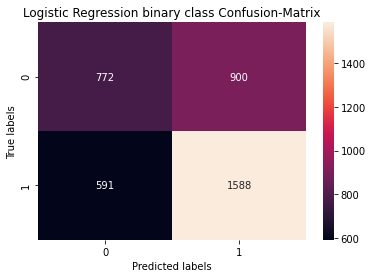

In [135]:
matrix=confusion_matrix(y_test, analysis_output) # getting the results of confusion matrix from the classification.
sns.heatmap(matrix, annot = True,fmt='g')       # printing the matrix
plt.title('Logistic Regression binary class Confusion-Matrix')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

#GaussionNB

In [136]:
classifier_biclass.set_params(clf=GaussianNB())
classifier_biclass.fit(X_train, y_train)
analysis_output = classifier_biclass.predict(X_test)
result_display()

Accuracy:  0.5614126200986757
              precision    recall  f1-score   support

       False       0.50      0.55      0.52      1672
        True       0.62      0.57      0.60      2179

    accuracy                           0.56      3851
   macro avg       0.56      0.56      0.56      3851
weighted avg       0.57      0.56      0.56      3851

[[ 921  751]
 [ 938 1241]]


#SVM Support vector machine

In [137]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_biclass.fit(X_train, y_train)
analysis_output = classifier_biclass.predict(X_test)
result_display()

Accuracy:  0.5585562191638536
              precision    recall  f1-score   support

       False       0.49      0.55      0.52      1672
        True       0.62      0.56      0.59      2179

    accuracy                           0.56      3851
   macro avg       0.56      0.56      0.56      3851
weighted avg       0.57      0.56      0.56      3851

[[ 921  751]
 [ 949 1230]]


#Decision Tress classifier

In [138]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier.set_params(clf=decision_tree)
classifier_biclass.fit(X_train, y_train)
analysis_output = classifier_biclass.predict(X_test)
result_display()

Accuracy:  0.5588158919761101
              precision    recall  f1-score   support

       False       0.49      0.56      0.52      1672
        True       0.62      0.56      0.59      2179

    accuracy                           0.56      3851
   macro avg       0.56      0.56      0.56      3851
weighted avg       0.57      0.56      0.56      3851

[[ 932  740]
 [ 959 1220]]


#Random Forest

In [139]:
classifier.set_params(clf=RandomForestClassifier())
classifier_biclass.fit(X_train, y_train)
analysis_output = classifier_biclass.predict(X_test)
result_display()

Accuracy:  0.5593352376006232
              precision    recall  f1-score   support

       False       0.49      0.55      0.52      1672
        True       0.62      0.57      0.59      2179

    accuracy                           0.56      3851
   macro avg       0.56      0.56      0.56      3851
weighted avg       0.57      0.56      0.56      3851

[[ 921  751]
 [ 946 1233]]
